In [3]:
import numpy as np
from os import walk, listdir
from os.path import isfile, join, exists
import pickle as pk
import json

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from numpy.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

from utils import get_encoded_vectors, load_test_files

In [4]:
url = 'http://172.17.0.1:5000/'

In [43]:
def project_edata(edata, pca_model = 'None', pca_list = 'None', space_d=2):
    #//TODO check if pca model exist, if no build new one. 
    if not exists(f'projection_models/{pca_model}.pkl'):
        # load all test data
        fnames, embeds = load_test_files(test_path = 'test_data')
        embeds = np.array(embeds)

        scaler = StandardScaler()
        # embeds = scaler.fit_transform(embeds)
        scaler.fit(embeds)
        
        # construct pca model 
        embeds = scaler.transform(embeds)
        pca = PCA(n_components=space_d)
        pca.fit(embeds)  
        
        # save model
        pk.dump(pca, open(f'projection_models/{pca_model}.pkl', "wb"))
        pk.dump(scaler, open(f'projection_models/scaler_{pca_model}.pkl', "wb"))
        
        # project all test data and save them
        t_pcas = pca.transform(embeds)
        np.save(f'pca_projected_embdes/{pca_list}.npy', t_pcas)
        np.save(f'pca_projected_embdes/{pca_list}_fnames.npy', fnames)
        
        # project test data using the same model
        edata = scaler.transform(edata)
        edata_pca = pca.transform(edata)
        
    else:
        # load pca model
        pca = pk.load(open(f'projection_models/{pca_model}.pkl', 'rb'))
        scaler = pk.load(open(f'projection_models/scaler_{pca_model}.pkl', 'rb'))
        # load projected test data
        t_pcas = np.load(f'pca_projected_embdes/{pca_list}.npy')
        fnames = np.load(f'pca_projected_embdes/{pca_list}_fnames.npy')
        # project test data using the same model
        edata = scaler.transform(edata)
        edata_pca = pca.transform(edata)
        
    return edata_pca, t_pcas, fnames

In [6]:
def calculate_distance(edata_pca, t_pcas, distance_fun='L1'):   
       
    if distance_fun =='L1' :
        dist = abs(edata_pca - t_pcas).sum(axis=1)
    elif distance_fun =='L2' :
        dist = np.square(edata_pca - t_pcas).sum(axis=1)
    elif distance_fun == 'RMSE' :
        dist = np.sqrt(np.square(edata_pca - t_pcas).sum(axis=1))
    elif distance_fun == 'cosine':
        dist = 1 - cosine_similarity(edata_pca, t_pcas)[0]
        # dist = (edata_pca @ t_pcas.T)/(norm(edata_pca)*norm(t_pcas))
    
    return dist

In [7]:
def find_similarities(edata, 
                      pca_model = 'None', pca_list = 'None', 
                      space_d=2, distance_fun='L1', n_candidates=3, plot=True):
    
    # Get PCA model, test projection, edata projection, files names
    edata_pca, t_pcas, fnames = project_edata(edata, pca_model, pca_list, space_d)
    
    #//TODO measure similarity 
    distance = calculate_distance(edata_pca, t_pcas, distance_fun)
    #//TODO return n of similar graphs.
    min_locs = np.argsort(distance)
    candidates_names = np.array(fnames)[min_locs[:n_candidates]]
    candidates_dist = distance[min_locs[:n_candidates]]

    if plot:
        plt.figure(figsize=(10,10))
        plt.scatter(t_pcas[min_locs[:n_candidates],0], t_pcas[min_locs[:n_candidates],1], c='blue')
        plt.scatter(t_pcas[min_locs[n_candidates:],0], t_pcas[min_locs[n_candidates:],1], c='orange')
        plt.scatter(edata_pca[0,0], edata_pca[0,1], c='red')
        plt.show()
        
    
    return candidates_names, candidates_dist

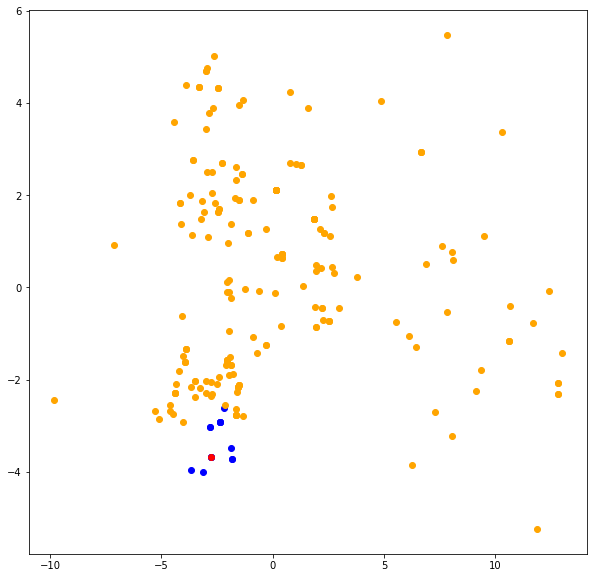

['test_data/sanofi_v2/data_CNC_0092.npy'
 'test_data/sanofi_v2/data_CNC_0090.npy'
 'test_data/sanofi_v2/data_CNC_0091.npy'
 'test_data/sanofi_v2/data_CNC_0089.npy'
 'test_data/sanofi_v2/data_MIX_0058.npy'
 'test_data/sanofi_v2/data_MIX_0059_draft.npy'
 'test_data/sanofi_v1/data_CNC_0032.npy'
 'test_data/sanofi_v2/data_MTR_0001.npy'
 'test_data/sanofi_v2/data_MTR_0002.npy'
 'test_data/sanofi_v2/data_CNC_0096.npy'
 'test_data/sanofi_v1/data_STO_0001.npy'
 'test_data/sanofi_v2/data_TEST VGO.npy'
 'test_data/sanofi_v2/data_STO_0006_Rev2 draft JRO.npy'
 'test_data/sanofi_v1/data_CNC_0012.npy'
 'test_data/sanofi_v1/data_MIX_0039.npy']
[1.97215226e-31 1.97215226e-31 1.97215226e-31 2.70354102e-01
 4.26059527e-01 4.26059527e-01 7.22323578e-01 7.22323578e-01
 7.22323578e-01 7.22323578e-01 7.93178554e-01 8.35698739e-01
 8.35698785e-01 9.28724437e-01 1.42049962e+00]


In [55]:
new_example = 'new-assemblies_13.10.2022-14.12.2022.json'
f = open(new_example)
data = json.load(f)

input_id = 77
inp_edges = data[input_id]["Edges"]

if len(inp_edges) > 0:
    encoded_data = get_encoded_vectors(url, data[input_id]["Edges"])['latent']
    cnames, cdist = find_similarities(np.array(encoded_data)[None,:], pca_model = 'sustain_trans_l1', pca_list = 'test1_pcas', 
                                      space_d=2, distance_fun='L2', n_candidates=15, plot=True)

    print(cnames)
    print(cdist)